# Gradient Boosted Decision Trees

For the second model I will use gradient boosted decision trees. This is an ensemble method that iteratively adds rather simple decision trees (weak base learners) where each tree is trained on the residuals of the sum of the previous trees. Important hyper-parameters are the number of trees, learning rate (to reduce overfitting) and properties of the trees (I use max_depth, min_samples_split; there are many more).

https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting  
https://towardsdatascience.com/machine-learning-part-18-boosting-algorithms-gradient-boosting-in-python-ef5ae6965be4  

In [1]:
# needs scikit-learn version >= 0.22 because of permutation_importance

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

from features import categorical_features, cols_idxs
from scores import save_score

## Read the data

In [2]:
df = pd.read_csv(os.path.join("data", "processed", "all_data2.csv"))
df.set_index("commune_id", inplace=True)
df.drop(columns=["name"], inplace=True)
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
df.drop(columns=vote_share_cols, inplace=True)

## Train/test split

In [3]:
# split the data into training (80%) and test (20%) sets
# we use stratification on the commune typology, which means that the proportions of the
# different typologies will be maintained in both sets (e.g. urban/rural)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df["typology"])
X_train = df_train.drop(columns="po_value").values
y_train = df_train["po_value"].values
X_test = df_test.drop(columns="po_value").values
y_test = df_test["po_value"].values

# numerical indexes for categorical features, will be needed in preprocessor later
categorical_idxs = cols_idxs(df.drop(columns="po_value"), categorical_features)

## First run (default parameters)

learning_rate =  0.1  
n_estimators = 100  
max_depth = 3  
min_samples_split = 2

In [4]:
# it is not necessary to standardize the features for decision trees

preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    remainder = "passthrough"
)

gtbr = make_pipeline(preprocessor, GradientBoostingRegressor(random_state=0))
gtbr.fit(X_train, y_train)
gtbr_test_pred = gtbr.predict(X_test)
print("With default params:")
print("GTBR MAE = {:.3f}".format(mean_absolute_error(y_test, gtbr_test_pred)))
print("GTBR R^2 = {:.3f}".format(gtbr.score(X_test, y_test)))

With default params:
GTBR MAE = 0.156
GTBR R^2 = 0.742


With default parameters, the model already performs almost as good as the best linear regression model (MAE = 0.153, $R^2$ = 0.749).

## Second run (tune learning_rate, n_estimators)

As suggested in https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/, I first tune the boosting-related hyper-parameters, learning_rate and n_estimators. Generally, lower learning rates do require more estimators.

In [5]:
parameters = {
    "gradientboostingregressor__learning_rate": [0.08, 0.09, 0.1, 0.11, 0.12 ],
    "gradientboostingregressor__n_estimators": np.linspace(100, 800, 8, dtype=int)
}
gcv_gtbr = GridSearchCV(gtbr, parameters, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12, return_train_score=True)
gcv_gtbr.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best params = {}".format(gcv_gtbr.best_params_))
print("Best MAE = {:.3f}".format(-gcv_gtbr.best_score_))
best_learning_rate = gcv_gtbr.best_params_["gradientboostingregressor__learning_rate"]
best_n_estimators = gcv_gtbr.best_params_["gradientboostingregressor__n_estimators"]

Grid search / cross-validation:
Best params = {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__n_estimators': 700}
Best MAE = 0.153


The best learning rate is 0.1 which is also default we used before. The best number of estimators is 700, much higher than the default 100.

In [6]:
gcv_gtbr_test_pred = gcv_gtbr.predict(X_test)
gcv_gtbr_test_mae = mean_absolute_error(y_test, gcv_gtbr_test_pred)
gcv_gtbr_test_r2 = r2_score(y_test, gcv_gtbr_test_pred)
print("On test data:")
print("Tuned GTBR MAE = {:.3f}".format(gcv_gtbr_test_mae))
print("Tuned GTBR R^2 = {:.3f}".format(gcv_gtbr_test_r2))

On test data:
Tuned GTBR MAE = 0.151
Tuned GTBR R^2 = 0.755


There is some improvement in the model performance by using more estimators. 

### Cross validation ranking

This gives an insight into which hyper-parameters yielded the best results. Looking at the the table below, one notices that the mean test scores are very similar. Secondly, it is curious than on rank 3 and 4 there is a lower learning rate together with a lower number of estimators (expected would be a higher number of estimators when the learning rate decreases). My interpretation is that these estimators have all very similar performance and there is an element of chance in the ranking.

In [7]:
df_gcv_gtbr = pd.DataFrame(gcv_gtbr.cv_results_)[
    ['rank_test_score', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score',
     'param_gradientboostingregressor__learning_rate', 'param_gradientboostingregressor__n_estimators']
    ].sort_values(by='rank_test_score')
df_gcv_gtbr.head()

,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,param_gradientboostingregressor__learning_rate,param_gradientboostingregressor__n_estimators
22,1,-0.032000,0.000554,-0.153449,0.005468,0.1,700
23,2,-0.026568,0.000506,-0.153595,0.005657,0.1,800
21,3,-0.038796,0.000611,-0.153754,0.005010,0.1,600
7,4,-0.035799,0.000761,-0.153762,0.005917,0.08,800
6,5,-0.041778,0.000739,-0.153897,0.005776,0.08,700


## Third run (tune max_depth, min_samples_split)

Next I am tuning the tree-related hyper-parameters max_depth and min_samples_split. 

In [8]:
parameters2 = {
    "gradientboostingregressor__learning_rate": [best_learning_rate],
    "gradientboostingregressor__n_estimators": [best_n_estimators],
    "gradientboostingregressor__max_depth": np.linspace(1, 10, 10),
    "gradientboostingregressor__min_samples_split": np.linspace(2, 10, 9, dtype=int)
}
gcv2_gtbr = GridSearchCV(gtbr, parameters2, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12, return_train_score=True)
gcv2_gtbr.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best params = {}".format(gcv2_gtbr.best_params_))
print("Best MAE = {:.3f}".format(-gcv2_gtbr.best_score_))
best_max_depth = gcv2_gtbr.best_params_["gradientboostingregressor__max_depth"]
best_min_samples_split = gcv2_gtbr.best_params_["gradientboostingregressor__min_samples_split"]

Grid search / cross-validation:
Best params = {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 3.0, 'gradientboostingregressor__min_samples_split': 7, 'gradientboostingregressor__n_estimators': 700}
Best MAE = 0.152


In [9]:
gcv2_gtbr_test_pred = gcv2_gtbr.predict(X_test)
gcv2__gtbr_test_mae = mean_absolute_error(y_test, gcv2_gtbr_test_pred)
gcv2_gtbr_test_r2 = r2_score(y_test, gcv2_gtbr_test_pred)
print("On test data:")
print("Tuned GTBR MAE = {:.3f}".format(gcv2__gtbr_test_mae))
print("Tuned GTBR R^2 = {:.3f}".format(gcv2_gtbr_test_r2))
save_score("gtbr", gcv2__gtbr_test_mae, gcv2_gtbr_test_r2, os.path.join("data", "results", "model_scores.csv"))

On test data:
Tuned GTBR MAE = 0.153
Tuned GTBR R^2 = 0.751


It is unfortunate that one the held-out test data, we get a slightly worse performance than with default max_depth and min_samples_split (but on the train set it was better). Playing by the rules, I stick with this result and save it as the final score for the gradient tree boosting.

Comparing with the linear regression model, the performance is practically identical. The capability of the gradient tree boosting model to capture more complex interactions between the features did not result in improved performance.

### Cross validation ranking

In [10]:
df_gcv2_gtbr = pd.DataFrame(gcv2_gtbr.cv_results_)[
    ['rank_test_score', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score',
     'param_gradientboostingregressor__learning_rate', 'param_gradientboostingregressor__n_estimators',
     'param_gradientboostingregressor__max_depth', 'param_gradientboostingregressor__min_samples_split']
    ].sort_values(by='rank_test_score')
df_gcv2_gtbr.head(5)

,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,param_gradientboostingregressor__learning_rate,param_gradientboostingregressor__n_estimators,param_gradientboostingregressor__max_depth,param_gradientboostingregressor__min_samples_split
23,1,-0.032346,0.000797,-0.151973,0.005115,0.1,700,3,7
21,2,-0.031874,0.000339,-0.152479,0.005620,0.1,700,3,5
29,3,-0.008455,0.000226,-0.152484,0.004468,0.1,700,4,4
34,4,-0.009273,0.000424,-0.152774,0.004816,0.1,700,4,9
33,5,-0.008786,0.000212,-0.153052,0.004536,0.1,700,4,8


Again, the test scores from the cross-validation are very similar. A maximum tree depth of 3 seems to be sufficient, using max depth of 4 does not result in better model performance.

### Plot real vs. predicted po

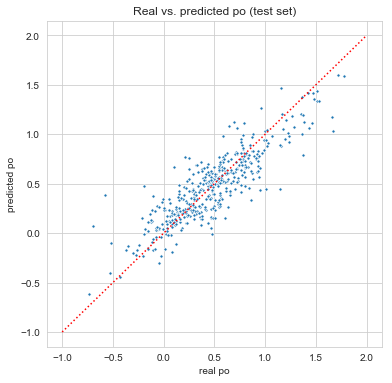

In [11]:
sns.set_style('whitegrid')
plt.figure(figsize=(6,6))
ax = sns.scatterplot(y_test, gcv2_gtbr_test_pred, s=10)
ax.set_xlabel("real po")
ax.set_ylabel("predicted po")
ax.set_title("Real vs. predicted po (test set)")
ax.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()

This looks similar to the plot from the linear regression model. Especially with respect to the fact that communes on the edges (po_value < 0.5 or po_value > 1.2) are predicted too centric.

## Influence of learning rate

I want to show the effect of different learning rates (0.8 and 0.12) and number of estimators on the error in the grid search. The tree-related hyper-parameters are fixed to the best values from above.

In [12]:
sns.set_style('whitegrid')
def validationcurve_plot(title, param_range, train_scores_mean, train_scores_std, valid_scores_mean, valid_scores_std, ax):
    """Plots a validation curve and marks the best test score."""

    sns.lineplot(param_range, train_scores_mean, label="train", ax=ax)
    ax.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)

    sns.lineplot(param_range, valid_scores_mean, label="validation", ax=ax)
    ax.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2)

    ax.set_title(title)
    ax.set_xlabel("n_estimators")

    best_idx = valid_scores_mean.values.argmin()
    ax.scatter(param_range[best_idx], valid_scores_mean[best_idx], marker='x', c='red', zorder=10, label="best")

    ax.legend()

In [13]:
# this is just for the charts
preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    remainder = "passthrough"
)
gtbr = make_pipeline(preprocessor, GradientBoostingRegressor(random_state=0))

param_range = np.append(np.linspace(10, 90, 9, dtype=int), np.linspace(100, 800, 8, dtype=int))
low_learning_rate = 0.08
high_learning_rate = 0.12
parameters3 = { "gradientboostingregressor__learning_rate": [low_learning_rate],
                "gradientboostingregressor__n_estimators": param_range,
                "gradientboostingregressor__max_depth": [best_max_depth],
                "gradientboostingregressor__min_samples_split": [best_min_samples_split] }
gcv3_gtbr = GridSearchCV(gtbr, parameters3, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12, return_train_score=True)
gcv3_gtbr.fit(X_train, y_train)
df_gcv3_gtbr = pd.DataFrame(gcv3_gtbr.cv_results_)

parameters4 = { "gradientboostingregressor__learning_rate": [high_learning_rate],
                "gradientboostingregressor__n_estimators": param_range,
                "gradientboostingregressor__max_depth": [best_max_depth],
                "gradientboostingregressor__min_samples_split": [best_min_samples_split] }
gcv4_gtbr = GridSearchCV(gtbr, parameters4, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12, return_train_score=True)
gcv4_gtbr.fit(X_train, y_train)
df_gcv4_gtbr = pd.DataFrame(gcv4_gtbr.cv_results_)

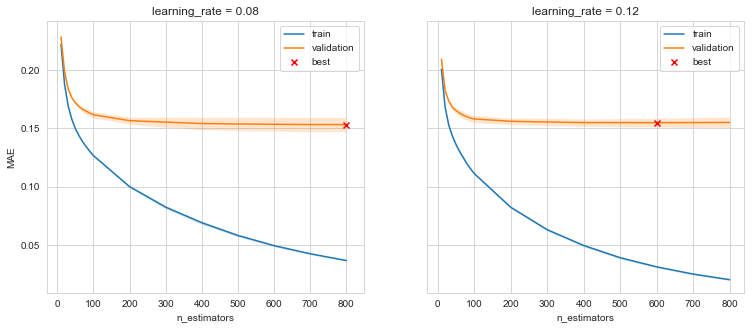

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5), sharey=True)
validationcurve_plot("learning_rate = 0.08", param_range, -df_gcv3_gtbr["mean_train_score"], -df_gcv3_gtbr["std_train_score"],
                     -df_gcv3_gtbr["mean_test_score"], -df_gcv3_gtbr["std_test_score"], ax=ax1)
ax1.set_ylabel("MAE")
validationcurve_plot("learning_rate = 0.12", param_range, -df_gcv4_gtbr["mean_train_score"], -df_gcv4_gtbr["std_train_score"],
                     -df_gcv4_gtbr["mean_test_score"], -df_gcv4_gtbr["std_test_score"], ax=ax2)

In [15]:
print("On test data:")
print("learning rate = 0.08: MAE={:.3f}".format(-gcv3_gtbr.score(X_test, y_test)))
print("learning rate = 0.12: MAE={:.3f}".format(-gcv4_gtbr.score(X_test, y_test)))

On test data:
learning rate = 0.08: MAE=0.151
learning rate = 0.12: MAE=0.155


The effect of the learning rate is clearly visible. For the lower learning rate, the error on the training set (which can get arbitrarily small) is shrinking slower, the "elbow" point where the error on the validation set keeps more or less the same is further right. That means a model with lower learning  rate requires more base estimators and is therefore more expensive in training and when predicting. What you get in return is better generalization, as can be seen from the better score on the held-out test set.

# Feature importance

Two ways to look at the feature importance of gradient tree boosting:
- permutation feature importance
- impurity-based feature importances of the trees

## Permutation feature importance
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#permutation-importance-with-multicollinear-or-correlated-features

To find the most important features, I will first use the same approach as with linear regression . I use the permutation_importance function of scikit-learn.

In [41]:
preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    remainder = "passthrough"
)
# using best parameters from grid search above
gtbr = make_pipeline(preprocessor,
                     GradientBoostingRegressor(random_state=0, learning_rate=best_learning_rate, n_estimators=best_n_estimators,
                                               max_depth=best_max_depth, min_samples_split=best_min_samples_split))
gtbr.fit(X_train, y_train)
tree_importances = gtbr.named_steps["gradientboostingregressor"].feature_importances_
perm_importances = permutation_importance(gtbr, X_train, y_train, scoring='neg_mean_absolute_error',
                                          n_repeats=10, n_jobs=12, random_state=0)
gtbr_test_pred = gtbr.predict(X_test)
gtbr_test_mae = mean_absolute_error(y_test, gtbr_test_pred)
gtbr_test_r2 = r2_score(y_test, gtbr_test_pred)
print("On test data:")
print("Tuned GTBR MAE = {:.3f}".format(gtbr_test_mae))
print("Tuned GTBR R^2 = {:.3f}".format(gtbr_test_r2))
print("(as above)")

On test data:
Tuned GTBR MAE = 0.153
Tuned GTBR R^2 = 0.751
(as above)


In [42]:
perm_sorted_idx = (-perm_importances["importances_mean"]).argsort()
perm_importances_sorted = perm_importances["importances_mean"][perm_sorted_idx]
cols_sorted = df_train.drop(columns="po_value").columns[perm_sorted_idx]

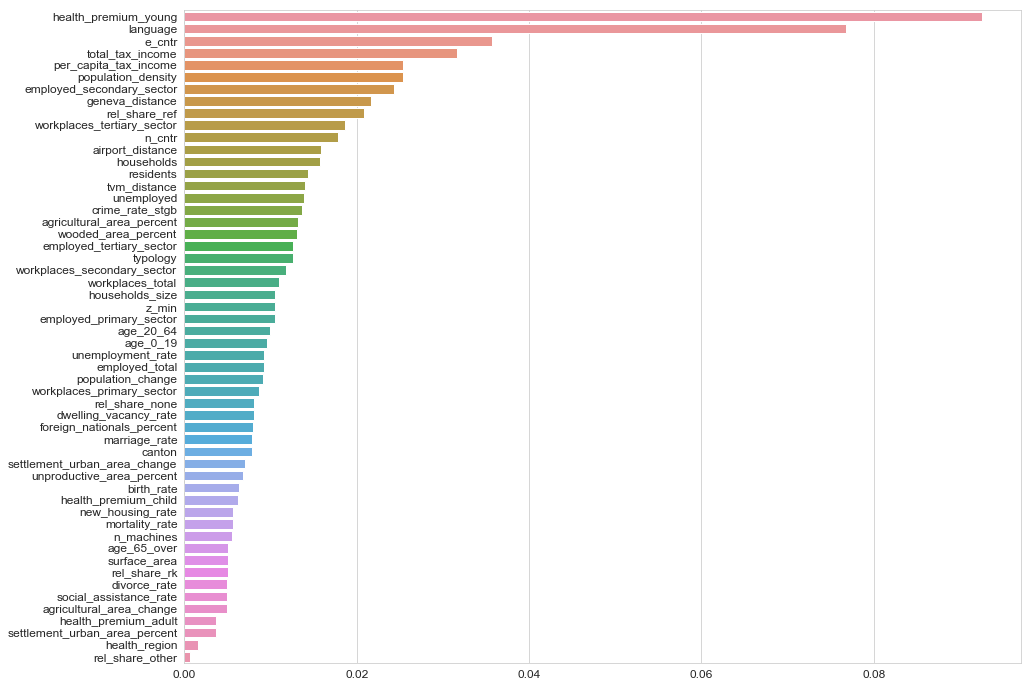

In [43]:
sns.set_style('whitegrid')
plt.figure(figsize = (15,12))
bp = sns.barplot(x=perm_importances_sorted, y=cols_sorted)
bp.tick_params(labelsize="large")

This looks different from the feature importances of the linear regression in two ways:
- the absolute importance of the top features is smaller (~0.08) compared to linear regression (~0.5)
- more features are important, the importance does not decrease as fast as in linear regression, where the first third of features is much more important than the rest; but careful, the scale of the plots is different

## Impurity-based feature importance

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor.feature_importances_

Decision trees are special with respect to feature importance because a measure of feature importance can be computed directly from the trees by looking at the features that are used to split the nodes. "The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance."

Note that the meaning of the numerical value is different from permutation feature importance and cannot be compared.

There is another difference: the importance is computed on the one-hot-encoded, cateporical features, because that is what the model is really trained on. (For permutation importance, I decided to put the one-hot-encoding in the pipeline, which means it happens *after* the feature_importance method permutes the features). That allows for additional insight what e.g. specific cantons or languages are important.

In [44]:
def get_column_names_of_one_hot_encoded_features(column_transformer, original_columns, categorical_features):
    ohe = column_transformer.named_transformers_["onehotencoder"]
    column_names = ohe.get_feature_names(categorical_features).tolist()
    for name in column_transformer.get_feature_names():
        if name.startswith("x"):
            column_names.append(original_columns[int(name[1:])])
    return np.array(column_names)

In [45]:
tree_sorted_idx = (-tree_importances).argsort()
tree_importances_sorted = tree_importances[tree_sorted_idx]
column_names = get_column_names_of_one_hot_encoded_features(gtbr.named_steps["columntransformer"],
                 df_train.drop(columns="po_value").columns, categorical_features)
tree_cols_sorted = column_names[tree_sorted_idx]

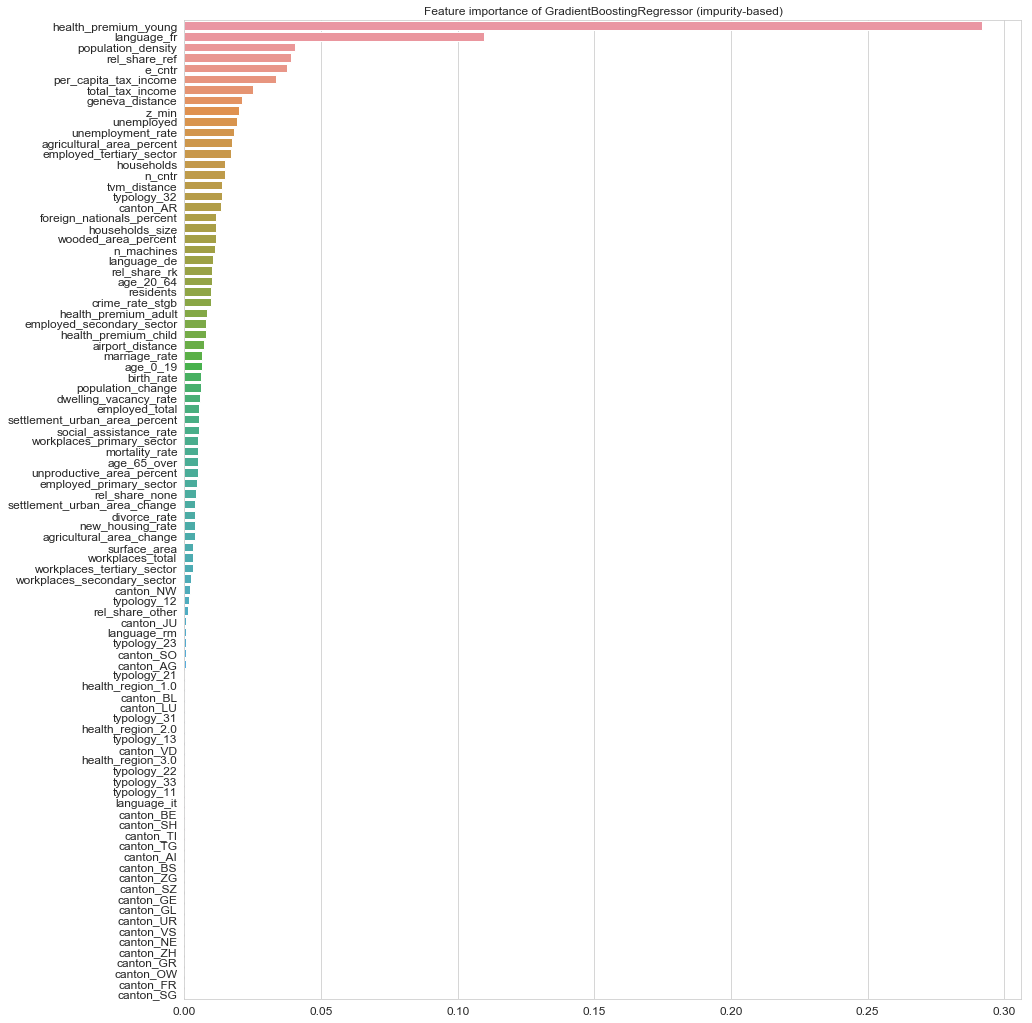

In [46]:
plt.figure(figsize = (15,18))
bp = sns.barplot(x=tree_importances_sorted, y=tree_cols_sorted)
bp.tick_params(labelsize="large")
bp.set_title("Feature importance of GradientBoostingRegressor (impurity-based)");

Interpretation:
- it is consistent: each of the top features of tree importance is also an important feature in permutation importance (not strictly in same order)
- as mentioned, we see the categorical features at the level of individual categories
- canton: an important feature in linear regression, not so much in tree boosting (lower half of permutation feature importance); the reason for this becomes clear: only the two cantons (AR and NW, two small and most right-oriented cantons, cf. EDA) are used; all the other cantons are not used by the model
- language: most important is the French language; in the EDA you can see that this concerns ~1/3 of communes, and they are on average more left; the rest class is dominated by German language, and Italian/Romanic communes are politically not so distinct from German ones; this makes the other languages unimportant 
- while east coordinate has been important in linear regression too, here we also have north coordinate and elevation (z_min) as important features; I suppose by using them in a non-linear way, the trees can much more use the geographic features to partition the map and are therefore not depending on canton very much

## With reduced features
Again I build a model with reduced feature set, around a dozen features. Other than with linear regression, I base the feature selection on the full-featured importance result.

In [47]:
reduced_features = [
    "health_premium_young",
    "language",
    "population_density",
    "rel_share_ref",
    "e_cntr",
    "n_cntr",
    "z_min",
    "per_capita_tax_income",
    "unemployment_rate",
    "agricultural_area_percent",
    "households", # instead of total_tax_income
    # "typology"
]

X_train_red = df_train[reduced_features].values
X_test_red = df_test[reduced_features].values

categorical_features_red = set(categorical_features).intersection(set(reduced_features))
categorical_idxs_red = cols_idxs(df[reduced_features], categorical_features_red)

In [48]:
preprocessor_red = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs_red),
    remainder = "passthrough"
)
# using best parameters from grid search above
gtbr_red = make_pipeline(preprocessor_red,
                         GradientBoostingRegressor(random_state=0, learning_rate=best_learning_rate, n_estimators=best_n_estimators,
                                                   max_depth=best_max_depth, min_samples_split=best_min_samples_split))
gtbr_red.fit(X_train_red, y_train)
perm_importances_red = permutation_importance(gtbr_red, X_train_red, y_train, scoring='neg_mean_absolute_error',
                                         n_repeats=10, n_jobs=12, random_state=0)
gtbr_red_test_pred = gtbr_red.predict(X_test_red)
gtbr_red_test_mae = mean_absolute_error(y_test, gtbr_red_test_pred)
gtbr_red_test_r2 = r2_score(y_test, gtbr_red_test_pred)
print("On test data:")
print("GTBR (red.) MAE = {:.3f}".format(gtbr_red_test_mae))
print("GTBR (red.) R^2 = {:.3f}".format(gtbr_red_test_r2))
save_score("gtbr_red", gtbr_red_test_mae, gtbr_red_test_r2, os.path.join("data", "results", "model_scores.csv"))

On test data:
GTBR (red.) MAE = 0.160
GTBR (red.) R^2 = 0.737


Similar to linear regression, reducing the number of features from 54 to 11 results in a model that is not much worse than the full-feature model.

| &nbsp; | full | red. |
| --- | --- | --- |
|MAE|0.153|0.160|
|$R^2$|0.750|0.735|

In [49]:
perm_sorted_idx_red = (-perm_importances_red["importances_mean"]).argsort()
perm_importances_sorted_red = perm_importances_red["importances_mean"][perm_sorted_idx_red]
cols_sorted_red = df_train[reduced_features].columns[perm_sorted_idx_red]

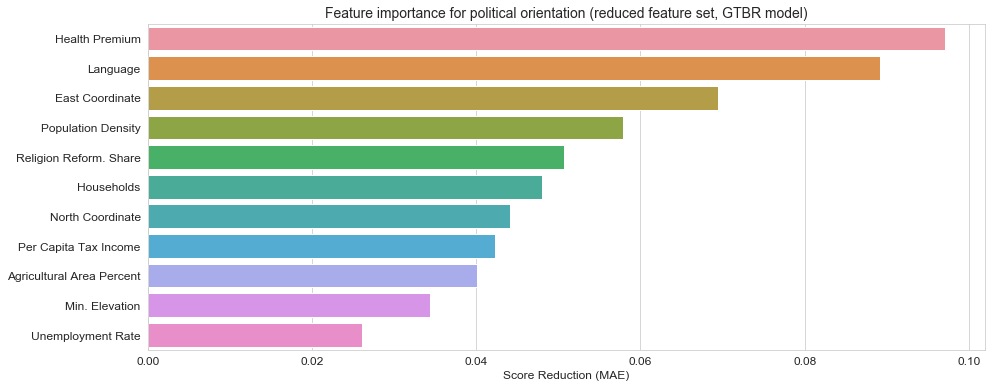

In [51]:
plt.figure(figsize = (15,6))
# print(cols_sorted_red)
# ['health_premium_young', 'language', 'e_cntr', 'population_density', 'rel_share_ref', 'households',
#  'n_cntr', 'per_capita_tax_income', 'agricultural_area_percent', 'z_min', 'unemployment_rate']
cols_nice = ['Health Premium', 'Language', 'East Coordinate', 'Population Density',
       'Religion Reform. Share', 'Households', 'North Coordinate', 'Per Capita Tax Income',
       'Agricultural Area Percent', 'Min. Elevation', 'Unemployment Rate']
bp_red = sns.barplot(x=perm_importances_sorted_red, y=cols_nice)
bp_red.tick_params(labelsize="large")
bp_red.set_title("Feature importance for political orientation (reduced feature set, GTBR model)", fontsize=14)
bp_red.set_xlabel("Score Reduction (MAE)", fontsize=12)
plt.show()

Summary: Two different ways to look at feature importance agree on the most important features. By choosing the highest ranked features, I built a model with 11 features with performance close to the full-featured model. The chosen features represent distinctive concepts like geography, population size, economy, language, health or religion. An important difference to the linear regression model is that canton is not included.